In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import itertools
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

In [39]:
# CSV 파일 로드
file_path = 'C:/Users/manci/Desktop/멀티잇_부트캠프/최종파이널_프로젝트/환율예측/data/딥러닝및머신러닝논문/2019.csv'

df = pd.read_csv(file_path)

# 날짜 칼럼 --> datetime 형태로 변환
df['날짜'] = pd.to_datetime(df['날짜'])


# 날짜 칼럼을 인덱스로 설정
df.set_index('날짜', inplace=True)

In [40]:
'''
### 상관분석
plt.figure(figsize = (13,13))
sns.heatmap(data = df.corr(), annot = True, fmt = '.2f', linewidths=.5, cmap='Blues')

# 상관계수 계산
corr_matrix = df.corr()

# 상관계수 절댓값 기준 설정 : 0.5 이상부터 양의 상관성
threshold = 0.5

# '환율'과 상관성이 0.5 이상인 칼럼 찾기
high_corr_columns = ['환율']

for col in corr_matrix.columns:
    if col != '환율' and corr_matrix.loc['환율', col] >= threshold:
        high_corr_columns.append(col)

# 결과 출력
print("환율과 상관성이 0.5 이상인 칼럼들:")
for col in high_corr_columns:
     print(f"칼럼 {col} 의 상관계수: {corr_matrix.loc['환율', col]}")
'''

'\n### 상관분석\nplt.figure(figsize = (13,13))\nsns.heatmap(data = df.corr(), annot = True, fmt = \'.2f\', linewidths=.5, cmap=\'Blues\')\n\n# 상관계수 계산\ncorr_matrix = df.corr()\n\n# 상관계수 절댓값 기준 설정 : 0.5 이상부터 양의 상관성\nthreshold = 0.5\n\n# \'환율\'과 상관성이 0.5 이상인 칼럼 찾기\nhigh_corr_columns = [\'환율\']\n\nfor col in corr_matrix.columns:\n    if col != \'환율\' and corr_matrix.loc[\'환율\', col] >= threshold:\n        high_corr_columns.append(col)\n\n# 결과 출력\nprint("환율과 상관성이 0.5 이상인 칼럼들:")\nfor col in high_corr_columns:\n     print(f"칼럼 {col} 의 상관계수: {corr_matrix.loc[\'환율\', col]}")\n'

In [41]:
# Feature Engineering: 이동평균 및 과거 환율 값 추가
df['환율_7일_평균'] = df['환율'].rolling(window=7).mean()

for i in range(1,8):
    df[f'환율_{i}일전'] = df['환율'].shift(i)
df.dropna(inplace=True)
df

,환율,EUR_KRW,GBP_KRW,JPY_KRW,EUR_USD,GBP_USD,JPY_USD,다우존스,S&P500,나스닥,...,WTI,KOSPI지수,환율_7일_평균,환율_1일전,환율_2일전,환율_3일전,환율_4일전,환율_5일전,환율_6일전,환율_7일전
날짜,,,,,,,,,,,,,,,,,,,,,
2019-01-11,1118.9,1284.599976,1423.500000,10.306000,1.151013,1.275396,0.009234,23995.949219,2596.260010,6971.479980,...,51.44,2075.57,1121.700000,1121.6,1121.7,1118.0,1125.2,1127.5,1119.0,1118.1
2019-01-14,1117.6,1281.500000,1437.000000,10.309000,1.146014,1.284984,0.009220,23909.839844,2582.610107,6905.919922,...,50.31,2064.52,1121.500000,1118.9,1121.6,1121.7,1118.0,1125.2,1127.5,1119.0
2019-01-15,1121.4,1286.800049,1444.000000,10.361000,1.147289,1.287498,0.009238,24065.589844,2610.300049,7023.830078,...,51.80,2097.18,1120.628571,1117.6,1118.9,1121.6,1121.7,1118.0,1125.2,1127.5
2019-01-16,1120.1,1281.099976,1444.699951,10.331000,1.141683,1.287217,0.009204,24207.160156,2616.100098,7034.689941,...,52.08,2106.10,1119.900000,1121.4,1117.6,1118.9,1121.6,1121.7,1118.0,1125.2
2019-01-17,1122.0,1274.400024,1441.500000,10.260000,1.139809,1.288577,0.009171,24370.099609,2635.959961,7084.459961,...,51.83,2107.06,1120.471429,1120.1,1121.4,1117.6,1118.9,1121.6,1121.7,1118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-15,1376.3,1469.267334,1781.827881,8.679485,1.088554,1.296680,0.006317,40211.718750,5631.220215,18472.570312,...,83.22,2860.92,1380.814286,1380.1,1385.6,1383.4,1379.4,1379.0,1381.9,1389.4
2024-07-16,1381.9,1507.609985,1794.552856,8.749447,1.090156,1.297000,0.006323,40954.480469,5667.200195,18509.339844,...,83.22,2866.09,1380.814286,1376.3,1380.1,1385.6,1383.4,1379.4,1379.0,1381.9
2024-07-17,1386.0,1506.310059,1794.226562,8.731158,1.090251,1.297769,0.006315,41198.078125,5588.270020,17996.919922,...,83.22,2843.29,1381.814286,1381.9,1376.3,1380.1,1385.6,1383.4,1379.4,1379.0


In [42]:
# 정답 컬럼 생성
df.loc[:,'target'] = df.loc[:,'환율']

X = df.iloc[:, :-1]
y = df.loc[:,['target']]

# 정규화 진행
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [43]:
# LSTM 입력 데이터 형태 변환
def make_dataset(X, y, time_steps):
    X_data_total = []
    y_data_total = []
    for start in np.arange(len(X)-time_steps):
        stop = start + time_steps
        # X_data --> 슬라이싱
        X_data = X[start:stop, :]
        X_data_total.append(X_data)
        # y_data --> 인덱싱
        y_data = y[stop]
        y_data_total.append(y_data)
    return np.array(X_data_total), np.array(y_data_total)

time_steps = 30
X_data,y_data = make_dataset(X = X_scaled, y = y_scaled, time_steps = time_steps)

In [44]:
# 학습용 / 평가용 데이터 생성
train_size = int(len(X_data) * 0.7)
valid_size = int(len(X_data) * 0.2)
test_size = len(X_data) - train_size - valid_size

X_train = X_data[0:train_size,:,:]
y_train = y_data[0:train_size,:]
X_valid = X_data[train_size:train_size + valid_size,:,:]
y_valid = y_data[train_size:train_size + valid_size,:]
X_test = X_data[train_size + valid_size:len(X_data),:,:]
y_test = y_data[train_size + valid_size:len(X_data),:]

In [8]:
'''
# 시드 고정
seed = 45
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# 하이퍼파라미터 설정
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'batch_size': [16, 32, 64],
    'optimizer_choice': ['adam', 'rmsprop'],
    'epochs': [5, 10, 20, 50],
    'regularization': [0.001, 0.01, 0.02]
}

best_params = None
best_rmse = float('inf')
results = []

# 하이퍼파라미터 튜닝
for params in ParameterGrid(param_grid):
    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(params['regularization'])))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=params['learning_rate']) if params['optimizer_choice'] == 'adam' else RMSprop(learning_rate=params['learning_rate'])
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=0)
    
    y_pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
    results.append({
        'params': params,
        'rmse': rmse
    })
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

print("Best parameters found: ", best_params)
print("Best RMSE: ", best_rmse)
'''

'\n# 시드 고정\nseed = 45\nrandom.seed(seed)\nnp.random.seed(seed)\ntf.random.set_seed(seed)\n\n# 하이퍼파라미터 설정\nparam_grid = {\n    \'learning_rate\': [0.1, 0.01, 0.001],\n    \'batch_size\': [16, 32, 64],\n    \'optimizer_choice\': [\'adam\', \'rmsprop\'],\n    \'epochs\': [5, 10, 20, 50],\n    \'regularization\': [0.001, 0.01, 0.02]\n}\n\nbest_params = None\nbest_rmse = float(\'inf\')\nresults = []\n\n# 하이퍼파라미터 튜닝\nfor params in ParameterGrid(param_grid):\n    model = Sequential()\n    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=tf.keras.regularizers.l2(params[\'regularization\'])))\n    model.add(Dropout(params[\'dropout\']))\n    model.add(Dense(1))\n    \n    optimizer = Adam(learning_rate=params[\'learning_rate\']) if params[\'optimizer_choice\'] == \'adam\' else RMSprop(learning_rate=params[\'learning_rate\'])\n    model.compile(loss=\'mean_squared_error\', optimizer=optimizer)\n    \n    early_stopping = EarlyStopping(monitor=\'val_loss\', 

In [9]:
# 'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.2, 'optimizer': 'adam', 'epochs': 5,
# {'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.3, 'optimizer': 'adam', 'epochs': 10, 'regularization': 0.01}
# best_params = {'learning_rate': 0.001, 'batch_size': 16, 'dropout': 0.2, 'optimizer': 'adam', 'epochs': 50, 'regularization': 0.001}
# {'learning_rate': 0.001, 'batch_size': 32, 'dropout': 0.1, 'optimizer': 'adam', 'epochs': 50, 'regularization': 0.001}
# 2021 {'batch_size': 16, 'epochs': 50, 'learning_rate': 0.01, 'optimizer_choice': 'adam', 'regularization': 0.001}
# 2019 {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'epochs': 20, 'regularization': 0.01}
# 시드 고정
seed = 45
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# 최적의 파라미터
best_params = {'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'epochs': 20, 'regularization': 0.01}

print(best_params)

{'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'adam', 'epochs': 20, 'regularization': 0.01}


In [10]:
# LSTM 모델 정의
tf.keras.backend.clear_session()
model = Sequential()
model.add(LSTM(64, kernel_regularizer=l2(best_params['regularization']),input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(best_params['dropout']))
model.add(Dense(1, kernel_regularizer=l2(best_params['regularization'])))

optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'],
                    validation_data=(X_valid, y_valid), shuffle=False, callbacks=[early_stopping])

# 모델 평가
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

C:\Users\manci\anaconda3\envs\stl\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.5447 - val_loss: 0.4029
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3520 - val_loss: 0.2667
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.2357 - val_loss: 0.1834
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1734 - val_loss: 0.1307
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1428 - val_loss: 0.1248
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1310 - val_loss: 0.0945
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0877 - val_loss: 0.0821
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0754 - val_loss: 0.0651
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0855 - val_loss: 0.0535
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0669 - val_loss: 0.0473
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0459 - val_loss: 0.0445
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

In [11]:
# 예측
train_predict = model.predict(X_train)
valid_predict = model.predict(X_valid)
test_predict = model.predict(X_test)

# 예측 값 정규화 이전으로 복원
train_predict = scaler_y.inverse_transform(train_predict)
valid_predict = scaler_y.inverse_transform(valid_predict)
test_predict = scaler_y.inverse_transform(test_predict)

# 원래 값 정규화 이전으로 복원
y_train_actual =  scaler_y.inverse_transform(y_train)
y_valid_actual =  scaler_y.inverse_transform(y_valid)
y_test_actual =  scaler_y.inverse_transform(y_test)


total_predict = np.concatenate([train_predict, valid_predict, test_predict])
total_actual = np.concatenate([y_train_actual, y_valid_actual, y_test_actual])

index = df.iloc[time_steps:].index
df_predict = pd.DataFrame(data = total_predict,index=index, columns=['예측환율'])
df_predict.loc[:,'실제환율'] = y.iloc[time_steps:].values
df_predict['예측환율'] = df_predict['예측환율'].astype(float).round(2)

# 인덱스를 '날짜' 칼럼으로 변환
df_predict.reset_index(inplace = True)
df_predict.rename(columns = {'index': '날짜'}, inplace = True)

print(df_predict)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
             날짜     예측환율    실제환율
0    2019-02-27  1132.26  1118.3
1    2019-02-28  1131.80  1117.8
2    2019-03-04  1131.38  1119.9
3    2019-03-05  1131.62  1125.0
4    2019-03-06  1131.90  1125.8
...         ...      ...     ...
1332 2024-07-15  1386.46  1376.3
1333 2024-07-16  1385.55  1381.9
1334 2024-07-17  1385.69  1386.0
1335 2024-07-18  1385.29  1381.5
1336 2024-07-19  1385.31  1379.9

[1337 rows x 3 columns]


In [12]:
### 성능 평가
def evaluate_performance(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, r2, mape

# 전체 데이터에 대한 성능 지표 계산
# overall_rmse, overall_mae, overall_r2, overall_mape = evaluate_performance(df_predict['실제환율'], df_predict['예측환율'])
# print(f'전체 RMSE: {overall_rmse}, 전체 MAE: {overall_mae}, 전체 R2: {overall_r2}, 전체 MAPE: {overall_mape}')
# print('-'*80)

overall_rmse, overall_mae, overall_r2, overall_mape = evaluate_performance(total_actual, total_predict)
print(f'전체 RMSE: {overall_rmse}, 전체 MAE: {overall_mae}, 전체 R2: {overall_r2}, 전체 MAPE: {overall_mape}')


print('-'*80)

# 각 데이터셋에 대한 성능 지표
train_rmse, train_mae, train_r2, train_mape = evaluate_performance(y_train_actual, train_predict)
valid_rmse, valid_mae, valid_r2, valid_mape = evaluate_performance(y_valid_actual, valid_predict)
test_rmse, test_mae, test_r2, test_mape = evaluate_performance(y_test_actual, test_predict)

print(f'Train RMSE: {train_rmse}, MAE: {train_mae}, R2: {train_r2}, MAPE: {train_mape}')
print('-'*80)
print(f'Valid RMSE: {valid_rmse}, MAE: {valid_mae}, R2: {valid_r2}, MAPE: {valid_mape}')
print('-'*80)
print(f'Test RMSE: {test_rmse}, MAE: {test_mae}, R2: {test_r2}, MAPE: {test_mape}')

전체 RMSE: 14.129343814447983, 전체 MAE: 10.581617963929274, 전체 R2: 0.9731419485159981, 전체 MAPE: 0.8536754509017863
--------------------------------------------------------------------------------
Train RMSE: 13.220733642076535, MAE: 9.798384807403076, R2: 0.9674640567127191, MAPE: 0.8115229764001997
--------------------------------------------------------------------------------
Valid RMSE: 18.50228341421811, MAE: 15.089167471324902, R2: 0.6082378245555746, MAPE: 1.167306078841975
--------------------------------------------------------------------------------
Test RMSE: 9.462042065426974, MAE: 7.091301540798612, R2: 0.8523806292454164, MAPE: 0.5253286805236617


In [13]:
### 향후 30일 예측 - 일별
future_dates = pd.date_range(start = df.index[-1] + pd.Timedelta(days = 1), periods = 30, freq='B')

future_preds = []
input_data = np.array(X_scaled[-30:])

for date in future_dates:
    # input_data를 모델 입력 형태에 맞게 reshape
    input_data_reshaped = input_data.reshape(1, 30, -1)
    pred = model.predict(input_data_reshaped)
    future_preds.append(pred[0])

    # When creating new_row, ensure all features are included
    new_row = np.append(input_data[0, 1:], pred[0])
    input_data = np.append(input_data[1:], new_row.reshape(1, -1), axis=0)

future_preds = scaler_y.inverse_transform(np.array(future_preds).reshape(-1, 1))

# 소수점 둘째자리까지 반올림
future_preds = np.round(future_preds, 2)

# 미래 예측 데이터프레임
future_df = pd.DataFrame({'예측날짜_일별': future_dates, '예측환율_일별':  future_preds.flatten()})

### 주말 포함 병합
dates = pd.date_range(start = df.index[-1] + pd.Timedelta(days = 1), periods = 42, freq='D')
new = pd.DataFrame({'예측날짜_일별' : dates})
pred_dates_df = pd.merge(new, future_df, on = '예측날짜_일별', how = 'left')

# 병합한 데이터 따로 저장
pred_dates_30 = pred_dates_df

# 원래 데이터 - 주말에는 금요일 환율로 대체
pred_dates_df = pred_dates_df.fillna(method = 'ffill')

# 예측 환율의 오차범위 만들기 - 예측환율_일별_최소 칼럼, 예측환율_일별_최대 칼럼 생성(소수점 둘째자리까지)
pred_dates_df['예측환율_일별'] = pred_dates_df['예측환율_일별'].apply(lambda x : round(x, 2))
pred_dates_df['예측환율_일별_최소'] = np.round(pred_dates_df['예측환율_일별'] - 1.96*np.std(pred_dates_df['예측환율_일별']), 2)
pred_dates_df['예측환율_일별_최대'] = np.round(pred_dates_df['예측환율_일별'] + 1.96*np.std(pred_dates_df['예측환율_일별']), 2)
pred_dates_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

C:\Users\manci\AppData\Local\Temp\ipykernel_34116\3333942387.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pred_dates_df = pred_dates_df.fillna(method = 'ffill')


,예측날짜_일별,예측환율_일별,예측환율_일별_최소,예측환율_일별_최대
0,2024-07-20,NaN,NaN,NaN
1,2024-07-21,NaN,NaN,NaN
2,2024-07-22,1385.17,1378.89,1391.45
3,2024-07-23,1386.75,1380.47,1393.03
4,2024-07-24,1386.92,1380.64,1393.20
5,2024-07-25,1387.39,1381.11,1393.67
6,2024-07-26,1387.18,1380.90,1393.46
7,2024-07-27,1387.18,1380.90,1393.46
8,2024-07-28,1387.18,1380.90,1393.46
9,2024-07-29,1386.76,1380.48,1393.04


In [14]:
### 일별 예측 저장
file_path1 = 'C:/Users/manci/Desktop/멀티잇_부트캠프/최종파이널_프로젝트/환율예측/data/딥러닝및머신러닝논문/환율예측_일별_LSTM(주말대체함).csv'

pred_dates_df.to_csv(file_path1, index = False)

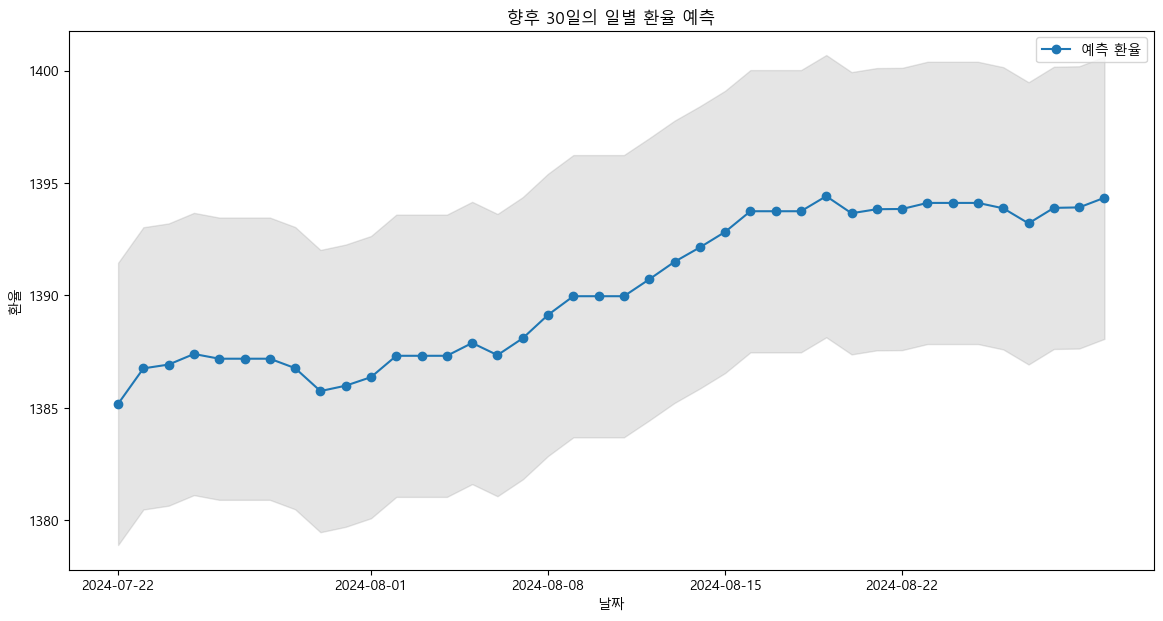

In [15]:
# 일별 예측 환율 시각화
plt.figure(figsize=(14, 7))
plt.plot(pred_dates_df['예측날짜_일별'], pred_dates_df['예측환율_일별'], label = '예측 환율', marker = 'o')
plt.fill_between(pred_dates_df['예측날짜_일별'], (pred_dates_df['예측환율_일별'] - 1.96*np.std(pred_dates_df['예측환율_일별'])), 
                 (pred_dates_df['예측환율_일별'] + 1.96*np.std(pred_dates_df['예측환율_일별'])), color='gray', alpha=0.2)
plt.title('향후 30일의 일별 환율 예측')
plt.xlabel('날짜')
plt.ylabel('환율')
plt.legend()
plt.show()

In [16]:
# 주말 제외 데이터
pred_dates_30['예측환율_일별'] = pred_dates_30['예측환율_일별'].apply(lambda x : round(x, 2))
pred_dates_30['예측환율_일별_최소'] = np.round(pred_dates_30['예측환율_일별'] - 1.96*np.std(pred_dates_30['예측환율_일별']), 2)
pred_dates_30['예측환율_일별_최대'] = np.round(pred_dates_30['예측환율_일별'] + 1.96*np.std(pred_dates_30['예측환율_일별']), 2)
pred_dates_30

,예측날짜_일별,예측환율_일별,예측환율_일별_최소,예측환율_일별_최대
0,2024-07-20,NaN,NaN,NaN
1,2024-07-21,NaN,NaN,NaN
2,2024-07-22,1385.17,1378.77,1391.57
3,2024-07-23,1386.75,1380.35,1393.15
4,2024-07-24,1386.92,1380.52,1393.32
5,2024-07-25,1387.39,1380.99,1393.79
6,2024-07-26,1387.18,1380.78,1393.58
7,2024-07-27,NaN,NaN,NaN
8,2024-07-28,NaN,NaN,NaN
9,2024-07-29,1386.76,1380.36,1393.16


In [17]:
# 주말 제외 데이터 저장
file_path5 = 'C:/Users/manci/Desktop/멀티잇_부트캠프/최종파이널_프로젝트/환율예측/data/딥러닝및머신러닝논문/환율예측_일별_LSTM(주말NaN값).csv'

pred_dates_30.to_csv(file_path5, index = False)

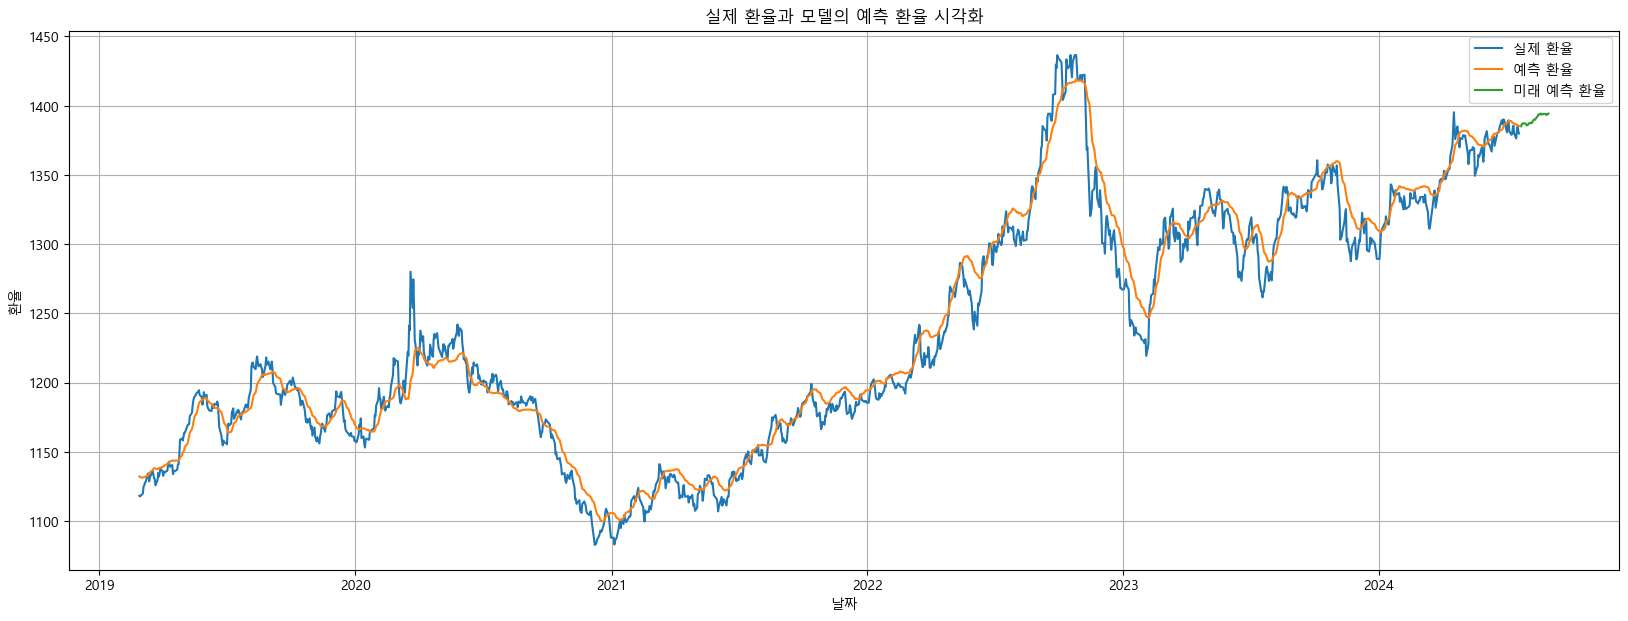

In [18]:
### model --> 결과 시각화
plt.figure(figsize=(20,7))
# df_predict.loc[:,['실제환율','예측환율']].plot(kind='line')
# Convert '예측날짜' to datetime objects and extract dates
plt.plot(df_predict['날짜'], df_predict['실제환율'], label = '실제 환율')
plt.plot(df_predict['날짜'], df_predict['예측환율'], label = '예측 환율', linestyle = 'solid')

# Convert '예측날짜' to datetime objects and extract dates
plt.plot(pd.to_datetime(pred_dates_df['예측날짜_일별']).dt.date, pred_dates_df['예측환율_일별'], 
         label = '미래 예측 환율', linestyle = 'solid')

#plt.fill_between(df_predict['날짜'],  (df_predict['예측환율'] - 1.96*np.std(total_predict)), (df_predict['예측환율'] + 1.96*np.std(total_predict)), color = 'gray', alpha=0.2)
plt.title('실제 환율과 모델의 예측 환율 시각화')
plt.xlabel('날짜')
plt.ylabel('환율')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
### 실제, 예측, 향후 30일 일별 예측 값 모두 합치기
# 예측 날짜와 예측 환율을 기존 데이터프레임에 추가
pred_dates_df.rename(columns={'예측날짜_일별': '날짜', '예측환율_일별': '예측환율'}, inplace=True)
pred_dates_df = pred_dates_df[['날짜', '예측환율']]

# df_predict와 pred_dates_df를 하나의 데이터프레임으로 결합
df_total = pd.concat([df_predict, pred_dates_df], ignore_index=True)

# 필요한 경우 날짜 순으로 정렬
df_total.sort_values(by='날짜', inplace=True)
df_total.reset_index(drop=True, inplace=True)

print(df_total)

             날짜     예측환율    실제환율
0    2019-02-27  1132.26  1118.3
1    2019-02-28  1131.80  1117.8
2    2019-03-04  1131.38  1119.9
3    2019-03-05  1131.62  1125.0
4    2019-03-06  1131.90  1125.8
...         ...      ...     ...
1374 2024-08-26  1393.87     NaN
1375 2024-08-27  1393.20     NaN
1376 2024-08-28  1393.89     NaN
1377 2024-08-29  1393.91     NaN
1378 2024-08-30  1394.34     NaN

[1379 rows x 3 columns]


In [20]:
### 실제, 예측, 향후 30일 일별 예측 값 모두 csv 저장
file_path100 = 'C:/Users/manci/Desktop/멀티잇_부트캠프/최종파이널_프로젝트/환율예측/data/딥러닝및머신러닝논문/실제_예측_total_LSTM(주말포함).csv'

df_total.to_csv(file_path100, index = False)

In [21]:
### 3개월 월별 예측
future_days = 60
future_month_dates = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_days, freq='B')

input_data = np.array(X_scaled[-30:])
future_month_preds = []

for date in future_month_dates:
    input_data_reshaped = input_data.reshape(1, 30, -1)
    pred1 = model.predict(input_data_reshaped)
    future_month_preds.append(pred1[0])
    new_row = np.append(input_data[0, 1:], pred1[0])
    input_data = np.append(input_data[1:], new_row.reshape(1, -1), axis=0)

future_month_preds = scaler_y.inverse_transform(np.array(future_month_preds).reshape(-1, 1))
future_month_preds = np.round(future_month_preds, 2)

# 미래 예측 데이터프레임
future_month_df = pd.DataFrame({'예측날짜_월별': future_month_dates, '예측환율_월별': future_month_preds.flatten()})

### 주말 포함 병합
dates1 = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=future_days, freq='D')
new1 = pd.DataFrame({'예측날짜_월별': dates1})
pred_month_df = pd.merge(new1, future_month_df, on='예측날짜_월별', how='left')
pred_month_df = pred_month_df.fillna(method='ffill')

# 월별 마지막 예측환율 값 찾기
pred_month_df['예측날짜_월별'] = pred_month_df['예측날짜_월별'].dt.to_period('M')
last_day_preds = pred_month_df.groupby('예측날짜_월별').last().reset_index()
last_day_preds.columns = ['예측날짜_월별', '예측환율_월별']

# 월별 마지막 예측환율 값 --> 월별 데이터로 넣기(날짜 형태 연도-월)
last_day_preds['예측날짜_월별'] = last_day_preds['예측날짜_월별'].dt.strftime('%Y-%m')
last_day_preds['예측환율_월별'] = last_day_preds['예측환율_월별'].apply(lambda x: round(x, 2))
last_day_preds['예측환율_월별_최소'] = np.round(last_day_preds['예측환율_월별'] - 1.96 * np.std(last_day_preds['예측환율_월별']), 2)
last_day_preds['예측환율_월별_최대'] = np.round(last_day_preds['예측환율_월별'] + 1.96 * np.std(last_day_preds['예측환율_월별']), 2)
last_day_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━

C:\Users\manci\AppData\Local\Temp\ipykernel_34116\3956820531.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pred_month_df = pred_month_df.fillna(method='ffill')


,예측날짜_월별,예측환율_월별,예측환율_월별_최소,예측환율_월별_최대
0,2024-07,1385.98,1373.09,1398.87
1,2024-08,1394.34,1381.45,1407.23
2,2024-09,1378.23,1365.34,1391.12


In [22]:
### 월별 예측 저장
file_path2 = 'C:/Users/manci/Desktop/멀티잇_부트캠프/최종파이널_프로젝트/환율예측/data/딥러닝및머신러닝논문/환율예측_월별_LSTM.csv'

last_day_preds.to_csv(file_path2, index = False)


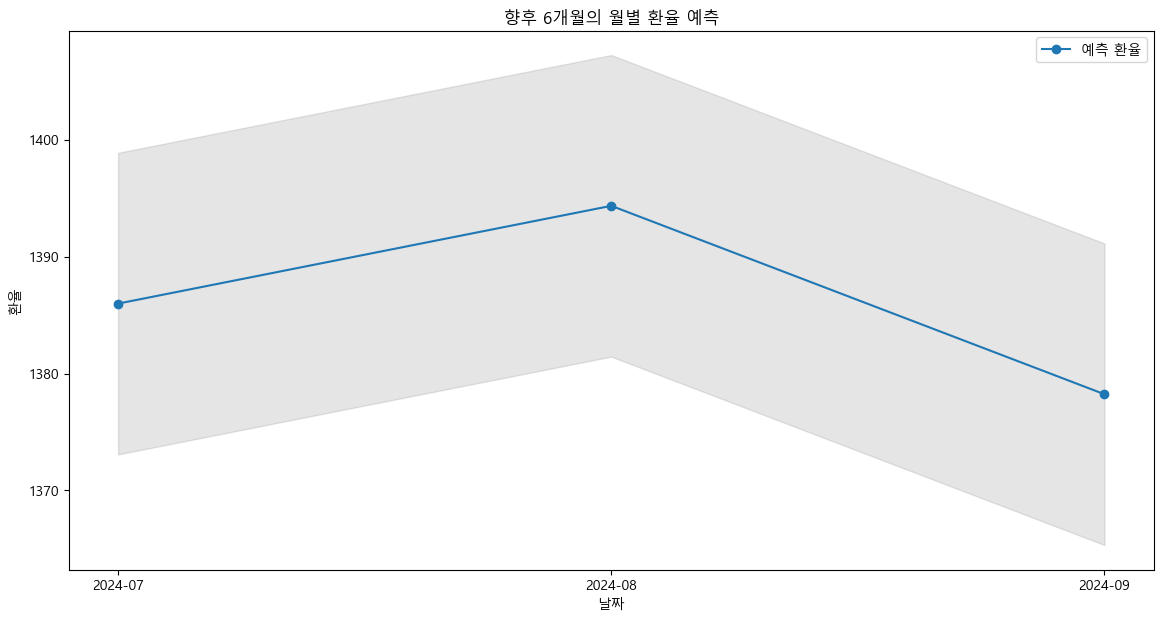

In [23]:
### 향후 3개월의 예측 환율 시각화
plt.figure(figsize=(14, 7))
plt.plot(last_day_preds['예측날짜_월별'], last_day_preds['예측환율_월별'], label = '예측 환율', marker = 'o')
plt.fill_between(last_day_preds['예측날짜_월별'], (last_day_preds['예측환율_월별'] - 1.96 * np.std(last_day_preds['예측환율_월별'])),
                 (last_day_preds['예측환율_월별'] + 1.96 * np.std(last_day_preds['예측환율_월별'])), color='gray', alpha=0.2)
plt.title('향후 6개월의 월별 환율 예측')
plt.xlabel('날짜')
plt.ylabel('환율')
plt.legend()
plt.show()

In [32]:
# 날짜에 따른 예측 결과 출력 함수
def get_prediction():
    while True:
        prediction_type = input("일별 예측을 원하시면 '일별', 월별 예측을 원하시면 '월별'을 입력하세요: ")
        if prediction_type not in ['일별', '월별']:
            print("잘못된 입력입니다. 다시 입력해주세요.")
            continue
        
        if prediction_type == '일별':
            print("가능한 일별 예측 날짜:")
            print(pred_dates_30['예측날짜_일별'].dt.strftime('%Y-%m-%d').tolist())
        elif prediction_type == '월별':
            print("가능한 월별 예측 날짜:")
            print(last_day_preds['예측날짜_월별'].tolist())
        
        date_input = input("날짜를 입력하세요 (형식: YYYY-MM-DD for 일별, YYYY-MM for 월별): ")
        
        try:
            if prediction_type == '일별':
                date = pd.to_datetime(date_input)
                if date in pred_dates_30['예측날짜_일별'].values:
                    row = pred_dates_30[pred_dates_30['예측날짜_일별'] == date]
                    if pd.isna(row['예측환율_일별'].values[0]):
                        print("해당 날짜는 주말이므로 환율 예측이 불가합니다.")
                    else:
                        print(f"{date_input}의 예측환율: {row['예측환율_일별'].values[0]}")
                        print(f"{date_input}의 예측환율 범위: {row['예측환율_일별_최소'].values[0]} ~ {row['예측환율_일별_최대'].values[0]}")
                else:
                    print("해당 날짜가 예측범위에 없습니다.")
            elif prediction_type == '월별':
                date = date_input
                if date in last_day_preds['예측날짜_월별'].values:
                    row = last_day_preds[last_day_preds['예측날짜_월별'] == date]
                    print(f"{date_input}의 예측환율: {row['예측환율_월별'].values[0]}")
                    print(f"{date_input}의 예측환율 범위: {row['예측환율_월별_최소'].values[0]} ~ {row['예측환율_월별_최대'].values[0]}")
                else:
                    print("해당 날짜가 예측범위에 없습니다.")
        except Exception as e:
            print("잘못된 날짜 형식입니다. 다시 입력해주세요.")
            continue
        break

# 예측 함수 호출
get_prediction()

일별 예측을 원하시면 '일별', 월별 예측을 원하시면 '월별'을 입력하세요:  월별


가능한 월별 예측 날짜:
['2024-07', '2024-08', '2024-09']


날짜를 입력하세요 (형식: YYYY-MM-DD for 일별, YYYY-MM for 월별):  2024-08


2024-08의 예측환율: 1394.34
2024-08의 예측환율 범위: 1381.45 ~ 1407.23


In [ ]:
### model --> 결과 시각화
plt.figure(figsize=(20,7))
# df_predict.loc[:,['실제환율','예측환율']].plot(kind='line')
# Convert '예측날짜' to datetime objects and extract dates
plt.plot(df_predict['날짜'], df_predict['실제환율'], label = '실제 환율')
plt.plot(df_predict['날짜'], df_predict['예측환율'], label = '예측 환율', linestyle = 'solid')

# Convert '예측날짜' to datetime objects and extract dates
plt.plot(pd.to_datetime(pred_dates_df['예측날짜_일별']).dt.date, pred_dates_df['예측환율_일별'], 
         label = '미래 예측 환율', linestyle = 'solid')

#plt.fill_between(df_predict['날짜'],  (df_predict['예측환율'] - 1.96*np.std(total_predict)), (df_predict['예측환율'] + 1.96*np.std(total_predict)), color = 'gray', alpha=0.2)
plt.title('실제 환율과 모델의 예측 환율 시각화')
plt.xlabel('날짜')
plt.ylabel('환율')
plt.grid(True)
plt.legend()
plt.show()